In [8]:
# ============================================
# 1. Import Necessary Libraries
# ============================================

import json
import numpy as np
import os
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    AdamW, 
    get_scheduler, 
    DataCollatorForSeq2Seq,
    pipeline
)
import torch
from torch.utils.data import Dataset, DataLoader
from spacy.matcher import Matcher
from difflib import SequenceMatcher
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")


In this section, the script generates synthetic financial transaction data to simulate a realistic dataset for training and testing purposes. The generate_financial_dataset function creates a specified number of samples, each representing a financial transaction with attributes such as company names, auditors, transaction types, accounts involved, transaction amounts, and potential anomalies. Each data point includes an input text describing the transaction and a corresponding list of triplets that encapsulate the relationships and entities within the transaction. The function ensures that directories exist for saving the generated data and outputs the data in a structured JSON format, which is essential for subsequent processing steps.

In [ ]:

# ============================================
# 2.1 Generate Synthetic Financial Dataset
# ============================================

def generate_financial_dataset(file_path, num_samples=1000):
    """
    Generates a synthetic financial dataset for training and evaluation.
    """
    companies = ["AlphaCorp", "BetaInc", "GammaLLC", "DeltaCo"]
    auditors = ["AuditPro", "VerifyIt", "CheckMate", "InsightAudit"]
    transaction_types = ["purchase", "sale", "transfer", "refund"]
    accounts = ["Accounts Receivable", "Accounts Payable", "Cash", "Inventory"]
    anomalies = [True, False]
    amounts = np.random.uniform(1000, 100000, size=num_samples)
    
    data = []
    for _ in range(num_samples):
        company = np.random.choice(companies)
        auditor = np.random.choice(auditors)
        transaction_id = f"T{np.random.randint(1000, 9999)}"
        transaction_type = np.random.choice(transaction_types)
        account = np.random.choice(accounts)
        amount = round(np.random.choice(amounts), 2)
        anomaly = np.random.choice(anomalies, p=[0.1, 0.9])  # 10% chance of anomaly

        input_text = (
            f"{company} reported a {transaction_type} transaction with ID {transaction_id} "
            f"affecting {account} account amounting to ${amount}. "
            f"The transaction was audited by {auditor}."
        )
        if anomaly:
            input_text += " An anomaly was detected in this transaction."

        triplets = [
            [company, "has transaction", transaction_id],
            [transaction_id, "is a", transaction_type],
            [transaction_id, "affects account", account],
            [transaction_id, "amounts to", f"${amount}"],
            [company, "audited by", auditor],
        ]
        if anomaly:
            triplets.append([transaction_id, "has anomaly", "True"])

        data.append({"input": input_text, "triplets": triplets})

    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)
    print(f"Financial dataset generated and saved to {file_path}")

# Generate the synthetic financial dataset
dataset_path = "./datasets/financial_dataset.json"
generate_financial_dataset(dataset_path, num_samples=20)

# Optionally, generate a test dataset
test_dataset_path = "./datasets/financial_test_dataset.json"
generate_financial_dataset(test_dataset_path, num_samples=4)


# ============================================
# 2.2 Generate Synthetic Financial Dataset (Extended)
# ============================================

def generate_financial_dataset_extended(file_path, num_samples=1000, 
                                        min_sentences=5, max_sentences=10,
                                        irrelevant_ratio=0.5,
                                        target_type='summarization'):
    """
    Generates a synthetic financial dataset with longer texts containing both relevant 
    and irrelevant information for training and evaluation.

    Args:
        file_path (str): Path to save the generated JSON dataset.
        num_samples (int): Number of samples to generate.
        min_sentences (int): Minimum number of sentences per sample.
        max_sentences (int): Maximum number of sentences per sample.
        irrelevant_ratio (float): Ratio of irrelevant sentences in each sample 
                                   (0.0 = all relevant, 1.0 = all irrelevant).
        target_type (str): Type of target. 'summarization' for relevant sentences,
                           'triplet_generation' for serialized triplets.
    """
    companies = ["AlphaCorp", "BetaInc", "GammaLLC", "DeltaCo", "EpsilonLtd", "ZetaSolutions"]
    auditors = ["AuditPro", "VerifyIt", "CheckMate", "InsightAudit", "SecureAudit", "PrimeVerify"]
    transaction_types = ["purchase", "sale", "transfer", "refund", "investment", "loan"]
    accounts = ["Accounts Receivable", "Accounts Payable", "Cash", "Inventory", "Revenue", "Expenses"]
    anomalies = [True, False]
    amounts = np.random.uniform(1000, 100000, size=num_samples)
    
    # Irrelevant content templates
    irrelevant_sentences = [
        "The quarterly financial results were impressive this year.",
        "Employee satisfaction surveys show a significant improvement.",
        "The company launched a new marketing campaign to boost sales.",
        "Recent updates to the software have enhanced user experience.",
        "There is a pending merger with another tech firm next quarter.",
        "Customer feedback has been overwhelmingly positive.",
        "The office renovation project has been completed successfully.",
        "A new initiative has been introduced to promote sustainability.",
        "Market trends indicate a growing demand for our products.",
        "The CEO will be attending an international business conference.",
        "Training programs have been updated to include new modules.",
        "The company received an award for excellence in customer service.",
        "New partnerships have been formed to expand our market reach.",
        "Inventory levels have been optimized to reduce holding costs.",
        "The annual general meeting is scheduled for next month."
    ]
    
    data = []
    for _ in range(num_samples):
        company = np.random.choice(companies)
        auditor = np.random.choice(auditors)
        transaction_id = f"T{np.random.randint(1000, 9999)}"
        transaction_type = np.random.choice(transaction_types)
        account = np.random.choice(accounts)
        amount = round(np.random.choice(amounts), 2)
        anomaly = np.random.choice(anomalies, p=[0.1, 0.9])  # 10% chance of anomaly

        # Relevant sentences
        relevant_sentences = [
            f"{company} reported a {transaction_type} transaction with ID {transaction_id}.",
            f"This transaction affects the {account} account.",
            f"The amount involved in this transaction is ${amount}.",
            f"The transaction was audited by {auditor}."
        ]
        if anomaly:
            relevant_sentences.append(f"An anomaly was detected in transaction {transaction_id}.")

        # Number of irrelevant sentences
        num_irrelevant = np.random.randint(
            int(min_sentences * irrelevant_ratio), 
            int(max_sentences * irrelevant_ratio) + 1
        )
        # Shuffle irrelevant sentences to select randomly
        selected_irrelevant = np.random.choice(
            irrelevant_sentences, 
            size=num_irrelevant, 
            replace=False
        ).tolist()
        
        # Total sentences
        total_sentences = relevant_sentences + selected_irrelevant
        np.random.shuffle(total_sentences)  # Shuffle to mix relevant and irrelevant sentences
        
        # Combine into a single text
        input_text = " ".join(total_sentences)
        
        # Prepare triplets
        triplets = [
            [company, "has transaction", transaction_id],
            [transaction_id, "is a", transaction_type],
            [transaction_id, "affects account", account],
            [transaction_id, "amounts to", f"${amount}"],
            [company, "audited by", auditor],
        ]
        if anomaly:
            triplets.append([transaction_id, "has anomaly", "True"])
        
        # Prepare target based on target_type
        if target_type == 'summarization':
            target_sentences = " ".join(relevant_sentences)
            target = target_sentences
        elif target_type == 'triplet_generation':
            # Serialize triplets into a string
            serialized_triplets = " ".join([f"{subj} {rel} {obj}." for subj, rel, obj in triplets])
            target = serialized_triplets
        else:
            raise ValueError("Invalid target_type. Choose 'summarization' or 'triplet_generation'.")
        
        data.append({
            "input": input_text, 
            "target": target,
            "triplets": triplets
        })

    # Ensure the directory exists
    os.makedirs(os.path.dirname(file_path), exist_ok=True)

    with open(file_path, "w") as file:
        json.dump(data, file, indent=4)
    print(f"Extended financial dataset generated and saved to {file_path}")

# Generate a small extended dataset for testing
dataset_path_extended = "./datasets/financial_dataset_extended.json"
generate_financial_dataset_extended(file_path=dataset_path_extended, num_samples=20, 
                                    min_sentences=5, max_sentences=10, irrelevant_ratio=0.6)

# Optionally, generate a test dataset with more irrelevant content
test_dataset_path_extended = "./datasets/financial_test_dataset_extended.json"
generate_financial_dataset_extended(file_path=test_dataset_path_extended, num_samples=4, 
                                    min_sentences=5, max_sentences=10, irrelevant_ratio=0.6)


Financial dataset generated and saved to ./datasets/financial_dataset.json
Financial dataset generated and saved to ./datasets/financial_test_dataset.json


This section focuses on loading the previously generated JSON datasets into the script using the load_json_dataset function. The function reads JSON files containing financial transaction data and converts them into pandas DataFrames for easier manipulation and analysis. After loading, the script converts the list of triplets associated with each transaction into a single concatenated string using the triplets_to_string function. This transformation is crucial for preparing the data in a format suitable for sequence-to-sequence modeling, where the model learns to map input texts to their corresponding triplet summaries. The script also prints out sample entries to verify the correctness and structure of the loaded data.

In [ ]:

# ============================================
# 3. Load and Preprocess Custom JSON Datasets
# ============================================

def load_json_dataset(file_path):
    """
    Loads a JSON dataset and converts it into a pandas DataFrame.

    Args:
        file_path (str): Path to the JSON file.

    Returns:
        pd.DataFrame: DataFrame containing the dataset.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
    df = pd.DataFrame(data)
    return df

# Paths to your datasets
train_dataset_path = "./datasets/financial_dataset.json"
test_dataset_path = "./datasets/financial_test_dataset.json"

# Extended datasets
# train_dataset_path = "./datasets/financial_dataset_extended.json"
# test_dataset_path = "./datasets/financial_test_dataset_extended.json"

# Load the datasets
train_df = load_json_dataset(train_dataset_path)
test_df = load_json_dataset(test_dataset_path)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# Convert triplets to string format for targets
def triplets_to_string(triplets):
    """
    Converts a list of triplets into a single string.

    Args:
        triplets (list): List of triplet lists.

    Returns:
        str: Concatenated string of triplets separated by periods.
    """
    triplet_strings = [f"{subj} {rel} {obj}" for subj, rel, obj in triplets]
    return ". ".join(triplet_strings)

train_df['target'] = train_df['triplets'].apply(triplets_to_string)
test_df['target'] = test_df['triplets'].apply(triplets_to_string)

# Inspect the first few entries
print("\nSample Training Data:")
print(train_df[['input', 'target']].head())


Training samples: 20
Testing samples: 4

Sample Training Data:
                                               input  \
0  GammaLLC reported a refund transaction with ID...   
1  DeltaCo reported a transfer transaction with I...   
2  AlphaCorp reported a refund transaction with I...   
3  GammaLLC reported a sale transaction with ID T...   
4  AlphaCorp reported a purchase transaction with...   

                                              target  
0  GammaLLC has transaction T7018. T7018 is a ref...  
1  DeltaCo has transaction T4721. T4721 is a tran...  
2  AlphaCorp has transaction T7436. T7436 is a re...  
3  GammaLLC has transaction T2637. T2637 is a sal...  
4  AlphaCorp has transaction T6449. T6449 is a pu...  


Tokenization is a critical preprocessing step in natural language processing tasks. In this section, the script initializes a tokenizer from the Hugging Face transformers library based on the specified model (e.g., t5-small). The tokenize_data function handles the conversion of input texts and their corresponding target triplet strings into tokenized formats that the transformer models can understand. It ensures that the inputs and targets are truncated or padded to predefined maximum lengths and that padding tokens in the labels are replaced with -100 to be ignored during loss computation. This structured tokenization facilitates efficient and effective training of the transformer models on the custom financial dataset.

In [11]:

# ============================================
# 4. Tokenize the Data
# ============================================

# Initialize the tokenizer
model_name = "t5-small"  # Default model; will iterate over multiple models later
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_data(inputs, targets, tokenizer, max_input_length=512, max_target_length=256):
    """
    Tokenizes input texts and target summaries.

    Args:
        inputs (list): List of input texts.
        targets (list): List of target summaries.
        tokenizer (transformers.PreTrainedTokenizer): Tokenizer to use.
        max_input_length (int): Maximum length for input tokens.
        max_target_length (int): Maximum length for target tokens.

    Returns:
        dict: Dictionary containing tokenized inputs and labels.
    """
    # Tokenize inputs
    input_encodings = tokenizer(
        inputs,
        max_length=max_input_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    # Tokenize targets
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(
            targets,
            max_length=max_target_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

    # Replace padding token id's in labels by -100 to ignore them in the loss
    labels = target_encodings['input_ids']
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        'input_ids': input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': labels
    }

# Tokenize training data
train_encodings = tokenize_data(
    inputs=train_df['input'].tolist(),
    targets=train_df['target'].tolist(),
    tokenizer=tokenizer,
    max_input_length=512,
    max_target_length=256
)

# Tokenize testing data
test_encodings = tokenize_data(
    inputs=test_df['input'].tolist(),
    targets=test_df['target'].tolist(),
    tokenizer=tokenizer,
    max_input_length=512,
    max_target_length=256
)


To enable efficient data handling and batching during model training, this section defines a custom PyTorch Dataset class named FinancialDataset. This class inherits from torch.utils.data.Dataset and encapsulates the tokenized inputs, attention masks, and labels. By overriding the __len__ and __getitem__ methods, it allows seamless integration with PyTorch's DataLoader, which is responsible for batching the data and shuffling it during training. The script creates instances of FinancialDataset for both training and testing datasets and then initializes DataLoader objects with a specified batch size, facilitating streamlined and parallel data processing during the training and evaluation phases.

In [12]:

# ============================================
# 5. Define Custom PyTorch Dataset and DataLoader
# ============================================

class FinancialDataset(Dataset):
    def __init__(self, encodings):
        """
        Initializes the dataset with tokenized encodings.

        Args:
            encodings (dict): Dictionary containing 'input_ids', 'attention_mask', and 'labels'.
        """
        self.input_ids = encodings['input_ids']
        self.attention_mask = encodings['attention_mask']
        self.labels = encodings['labels']

    def __len__(self):
        return self.input_ids.size(0)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

# Create PyTorch datasets
train_dataset = FinancialDataset(train_encodings)
test_dataset = FinancialDataset(test_encodings)

print(f"\nTokenized training samples: {len(train_dataset)}")
print(f"Tokenized testing samples: {len(test_dataset)}")

# Define batch size
batch_size = 16

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)



Tokenized training samples: 20
Tokenized testing samples: 4


The KnowledgeGraphPipeline class serves as the core component of the script, encapsulating all functionalities related to model initialization, fine-tuning, triplet extraction, knowledge graph construction, visualization, and evaluation. Upon initialization, it loads a specified transformer model and tokenizer, sets up SpaCy's transformer-based NLP pipeline, and defines custom entity and relation patterns tailored to the financial domain. The class provides methods to extract key sentences from input texts using the transformer model, identify and extract relevant triplets using SpaCy's Matcher, build directed knowledge graphs with networkx, visualize these graphs using matplotlib, and evaluate the extracted triplets against ground truth data using precision, recall, and F1 scores. Additionally, the class includes a fine_tune method that handles the fine-tuning of the transformer model on the custom dataset using a PyTorch-based training loop, optimizing the model's performance for the specific task at hand.

In [13]:

# ============================================
# 6. Define the KnowledgeGraphPipeline Class
# ============================================

class KnowledgeGraphPipeline:
    def __init__(self, model_name, device=None):
        """
        Initializes the pipeline with a transformer model and SpaCy.

        Args:
            model_name (str): Pre-trained model name.
            device (str, optional): Device to use ('cuda' or 'cpu'). Defaults to auto-detect.
        """
        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(self.device)
        self.nlp = spacy.load("en_core_web_trf")  # Use transformer-based SpaCy model
        self.add_financial_entities()  # Add domain-specific patterns
        self.matcher = Matcher(self.nlp.vocab)
        self.add_relation_patterns()
        self.model_name = model_name

    def add_financial_entities(self):
        """
        Adds custom financial entity patterns to SpaCy's NER.
        """
        ruler = self.nlp.add_pipe("entity_ruler", before="ner")
        patterns = [
            {"label": "ORG", "pattern": [{"LOWER": "alphacorp"}]},
            {"label": "ORG", "pattern": [{"LOWER": "betainc"}]},
            {"label": "ORG", "pattern": [{"LOWER": "gammallc"}]},
            {"label": "ORG", "pattern": [{"LOWER": "deltaco"}]},
            {"label": "ORG", "pattern": [{"LOWER": "auditpro"}]},
            {"label": "ORG", "pattern": [{"LOWER": "verifyit"}]},
            {"label": "ORG", "pattern": [{"LOWER": "checkmate"}]},
            {"label": "ORG", "pattern": [{"LOWER": "insightaudit"}]},
            {"label": "TRANSACTION_ID", "pattern": [{"TEXT": {"REGEX": "^T\\d+"}}]},
            {"label": "ACCOUNT", "pattern": [{"LOWER": "accounts"}, {"LOWER": "receivable"}]},
            {"label": "ACCOUNT", "pattern": [{"LOWER": "accounts"}, {"LOWER": "payable"}]},
            {"label": "ACCOUNT", "pattern": [{"LOWER": "cash"}]},
            {"label": "ACCOUNT", "pattern": [{"LOWER": "inventory"}]},
            {"label": "MONEY", "pattern": [{"TEXT": {"REGEX": "^\\$\\d+"}}]},
            {"label": "TRANSACTION_TYPE", "pattern": [{"LOWER": "purchase"}]},
            {"label": "TRANSACTION_TYPE", "pattern": [{"LOWER": "sale"}]},
            {"label": "TRANSACTION_TYPE", "pattern": [{"LOWER": "transfer"}]},
            {"label": "TRANSACTION_TYPE", "pattern": [{"LOWER": "refund"}]},
            {"label": "ANOMALY", "pattern": [{"LOWER": "anomaly"}]},
        ]
        ruler.add_patterns(patterns)

    def add_relation_patterns(self):
        """
        Adds patterns to extract relations using SpaCy's Matcher.
        """
        # Pattern for "ORG reported a TRANSACTION_TYPE transaction with ID TRANSACTION_ID"
        pattern1 = [
            {"ENT_TYPE": "ORG"},
            {"LEMMA": "report"},
            {"LOWER": "a"},
            {"ENT_TYPE": "TRANSACTION_TYPE"},
            {"LOWER": "transaction"},
            {"LOWER": "with"},
            {"LOWER": "id"},
            {"ENT_TYPE": "TRANSACTION_ID"},
        ]
        # Pattern for "TRANSACTION_ID affects ACCOUNT"
        pattern2 = [
            {"ENT_TYPE": "TRANSACTION_ID"},
            {"LEMMA": "affect"},
            {"ENT_TYPE": "ACCOUNT"},
        ]
        # Pattern for "TRANSACTION_ID amounts to MONEY"
        pattern3 = [
            {"ENT_TYPE": "TRANSACTION_ID"},
            {"LEMMA": "amount"},
            {"LOWER": "to"},
            {"ENT_TYPE": "MONEY"},
        ]
        # Pattern for "The transaction was audited by ORG"
        pattern4 = [
            {"LOWER": "the"},
            {"LOWER": "transaction"},
            {"LEMMA": "be"},
            {"LEMMA": "audit"},
            {"LOWER": "by"},
            {"ENT_TYPE": "ORG"},
        ]
        # Pattern for "Anomaly was detected in this transaction"
        pattern5 = [
            {"ENT_TYPE": "ANOMALY"},
            {"LEMMA": "be"},
            {"LEMMA": "detect"},
            {"LOWER": "in"},
            {"LOWER": "this"},
            {"LOWER": "transaction"},
        ]
        self.matcher.add("HAS_TRANSACTION", [pattern1])
        self.matcher.add("AFFECTS_ACCOUNT", [pattern2])
        self.matcher.add("AMOUNTS_TO", [pattern3])
        self.matcher.add("AUDITED_BY", [pattern4])
        self.matcher.add("HAS_ANOMALY", [pattern5])

    def extract_key_sentences(self, text):
        """
        Extracts key sentences using the fine-tuned transformer model.

        Args:
            text (str): Input text.

        Returns:
            str: Summarized key sentences.
        """
        input_ids = self.tokenizer(
            text, return_tensors="pt", max_length=512, truncation=True
        ).input_ids.to(self.device)

        outputs = self.model.generate(
            input_ids=input_ids,
            max_length=150,
            num_beams=4,
            no_repeat_ngram_size=2,
            early_stopping=True,
        )
        summarized_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        clean_sentences = [sent.strip() for sent in summarized_text.split(".") if sent.strip()]
        return ". ".join(clean_sentences)

    def normalize_triple(self, triple):
        """
        Normalize a triple by lowercasing and stripping extra spaces.

        Args:
            triple (tuple): A triple (subject, relation, object).

        Returns:
            tuple: Normalized triple.
        """
        subj, rel, obj = triple
        return subj.lower().strip(), rel.lower().strip(), obj.lower().strip()

    def extract_entities_and_relations(self, text):
        """
        Extracts entities and relations from the text using SpaCy's Matcher.

        Args:
            text (str): Input text.

        Returns:
            list: List of extracted triplets.
        """
        doc = self.nlp(text)
        matches = self.matcher(doc)
        relations = []

        for match_id, start, end in matches:
            span = doc[start:end]
            match_label = self.nlp.vocab.strings[match_id]

            if match_label == "HAS_TRANSACTION":
                org = span[0].text
                transaction_id = span[-1].text
                relations.append((org, "has transaction", transaction_id))
                transaction_type = span[3].text
                relations.append((transaction_id, "is a", transaction_type))

            elif match_label == "AFFECTS_ACCOUNT":
                transaction_id = span[0].text
                account = span[2].text
                relations.append((transaction_id, "affects account", account))

            elif match_label == "AMOUNTS_TO":
                transaction_id = span[0].text
                amount = span[-1].text
                relations.append((transaction_id, "amounts to", amount))

            elif match_label == "AUDITED_BY":
                # Extract the transaction_id from context or define a mapping
                # For simplicity, assuming the last transaction mentioned
                if relations:
                    transaction_id = relations[-1][2]  # Get the last transaction_id
                else:
                    transaction_id = "Unknown_TID"
                auditor = span[-1].text
                relations.append((transaction_id, "audited by", auditor))

            elif match_label == "HAS_ANOMALY":
                # Assuming the anomaly is related to the last transaction
                if relations:
                    transaction_id = relations[-1][2]
                else:
                    transaction_id = "Unknown_TID"
                relations.append((transaction_id, "has anomaly", "True"))

        # Remove duplicate triplets
        relations = list(set(relations))
        return relations

    def build_graph(self, relations):
        """
        Builds a knowledge graph using NetworkX.

        Args:
            relations (list): List of triplets.

        Returns:
            nx.DiGraph: Directed graph representing the knowledge graph.
        """
        G = nx.DiGraph()
        for subj, rel, obj in relations:
            G.add_edge(subj, obj, label=rel)
        return G

    def visualize_graph(self, G, title="Knowledge Graph"):
        """
        Visualizes the graph.

        Args:
            G (nx.DiGraph): The knowledge graph.
            title (str, optional): Title of the graph. Defaults to "Knowledge Graph".
        """
        pos = nx.spring_layout(G, seed=10)
        plt.figure(figsize=(8, 6))
        nx.draw(G, pos, with_labels=True, node_size=3000, font_size=10, node_color="lightblue", edge_color="gray")
        edge_labels = nx.get_edge_attributes(G, "label")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
        plt.title(title)
        plt.show()

    def evaluate_predictions(self, predicted_triples, true_triples, similarity_threshold=0.7):
        """
        Evaluates predicted triples against ground truth using relaxed one-to-one matching.

        Args:
            predicted_triples (list): List of predicted triplets.
            true_triples (list): List of true triplets.
            similarity_threshold (float, optional): Threshold for considering a match. Defaults to 0.7.

        Returns:
            tuple: Precision, Recall, F1 scores.
        """
        predicted_triples = [self.normalize_triple(triple) for triple in predicted_triples]
        true_triples = [self.normalize_triple(triple) for triple in true_triples]

        true_positives = 0
        unmatched_true_triples = set(tuple(triplet) for triplet in true_triples)
        unmatched_predicted_triples = set(tuple(triplet) for triplet in predicted_triples)

        for predicted in predicted_triples:
            for true in list(unmatched_true_triples):
                if all(SequenceMatcher(None, p, t).ratio() > similarity_threshold for p, t in zip(predicted, true)):
                    true_positives += 1
                    unmatched_true_triples.remove(true)
                    unmatched_predicted_triples.remove(predicted)
                    break

        precision = true_positives / len(predicted_triples) if predicted_triples else 0
        recall = true_positives / len(true_triples) if true_triples else 0
        f1 = (2 * precision * recall / (precision + recall)) if (precision + recall) > 0 else 0

        return precision, recall, f1

    def run_pipeline(self, text, true_triples=None, visualize=True):
        """
        Runs the complete pipeline on input text.

        Args:
            text (str): Input text.
            true_triples (list, optional): Ground truth triplets. Defaults to None.
            visualize (bool, optional): Whether to visualize the graph. Defaults to True.

        Returns:
            tuple: Predicted triplets and the knowledge graph.
        """
        key_sentences = self.extract_key_sentences(text)
        print(f"Key Sentences:\n{key_sentences}\n")

        predicted_triples = self.extract_entities_and_relations(key_sentences)
        print(f"Predicted Triples:\n{predicted_triples}\n")

        graph = self.build_graph(predicted_triples)

        if visualize:
            self.visualize_graph(graph, title=f"Knowledge Graph: {self.model_name}")

        if true_triples:
            precision, recall, f1 = self.evaluate_predictions(predicted_triples, true_triples)
            print(f"Evaluation - Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}\n")

        return predicted_triples, graph

    def fine_tune(self, train_loader, val_loader, output_dir="./fine_tuned_model", num_train_epochs=3, learning_rate=5e-5):
        """
        Fine-tunes the model on a provided training and validation DataLoader.

        Args:
            train_loader (DataLoader): DataLoader for training data.
            val_loader (DataLoader): DataLoader for validation data.
            output_dir (str, optional): Where to save the fine-tuned model. Defaults to "./fine_tuned_model".
            num_train_epochs (int, optional): Number of training epochs. Defaults to 3.
            learning_rate (float, optional): Learning rate for the optimizer. Defaults to 5e-5.
        """
        # Initialize the optimizer
        optimizer = AdamW(self.model.parameters(), lr=learning_rate)

        # Total number of training steps
        num_training_steps = num_train_epochs * len(train_loader)

        # Initialize the learning rate scheduler
        lr_scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        # Initialize tqdm for progress tracking
        progress_bar = tqdm(range(num_training_steps), desc="Training Progress")

        # Set the model to training mode
        self.model.train()

        for epoch in range(num_train_epochs):
            print(f"\nEpoch {epoch + 1}/{num_train_epochs}")
            for batch in train_loader:
                # Move batch to the appropriate device
                batch = {k: v.to(self.device) for k, v in batch.items()}

                # Forward pass
                outputs = self.model(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    labels=batch['labels']
                )
                loss = outputs.loss

                # Backward pass
                loss.backward()

                # Gradient clipping (optional but recommended)
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                # Optimizer step
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

                # Update progress bar
                progress_bar.update(1)
                progress_bar.set_description(f"Loss: {loss.item():.4f}")

        # Save the fine-tuned model
        self.model.save_pretrained(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        print(f"\nFine-tuned model saved to {output_dir}")


 Instantiate and Fine-Tune Multiple Models
This section automates the process of fine-tuning multiple transformer models on the custom financial dataset. It defines a list of models (e.g., t5-small, t5-base, t5-large) and iterates over each model to perform the following steps:

Initialization: Creates an instance of the KnowledgeGraphPipeline for the current model.
Data Splitting: Divides the training data into training and validation subsets to monitor the model's performance during fine-tuning.
Tokenization: Tokenizes the validation data using the current model's tokenizer.
DataLoader Preparation: Creates a DataLoader for the validation dataset.
Fine-Tuning: Calls the fine_tune method to train the model on the training data while evaluating it on the validation set.
Evaluation: After fine-tuning, the script evaluates the model's performance on a subset of the test data (e.g., the first 100 samples) and records the precision, recall, and F1 scores.
This loop ensures that each model undergoes identical training and evaluation procedures, facilitating a fair comparison of their performances on the task of extracting and summarizing financial triplets.

In [16]:

# ============================================
# 7. Instantiate and Fine-Tune Multiple Models
# ============================================

# Define the list of models to fine-tune and evaluate
models = [
    "t5-small",
    "facebook/bart-base",
    "google/flan-t5-small"
]
# Define a dictionary to store evaluation metrics for each model
evaluation_metrics = {}

for model_name in models:
    print(f"\n{'='*50}")
    print(f"Processing Model: {model_name}")
    print(f"{'='*50}\n")
    
    # Initialize the pipeline for the current model
    pipeline_kg = KnowledgeGraphPipeline(model_name=model_name)
    
    # Split training data into training and validation sets (if not already done)
    # Here, we'll use 90% for training and 10% for validation
    train_subset_df, val_subset_df = train_test_split(train_df, test_size=0.1, random_state=42)
    
    # Tokenize validation data with the current tokenizer
    val_encodings = tokenize_data(
        inputs=val_subset_df['input'].tolist(),
        targets=val_subset_df['target'].tolist(),
        tokenizer=pipeline_kg.tokenizer,
        max_input_length=512,
        max_target_length=256
    )
    
    # Create PyTorch dataset and DataLoader for validation
    val_dataset = FinancialDataset(val_encodings)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Fine-tune the model
    output_directory = f"./fine_tuned_models/{model_name}_fine-tunned"
    pipeline_kg.fine_tune(
        train_loader=train_loader,
        val_loader=val_loader,
        output_dir=output_directory,
        num_train_epochs=3,
        learning_rate=5e-5
    )
    
    # ============================================
    # 8. Evaluate the Fine-Tuned Model
    # ============================================
    
    # Function to evaluate on a subset of test data
    def evaluate_pipeline(pipeline, df, num_samples=100):
        """
        Evaluates the pipeline on a subset of the dataset.

        Args:
            pipeline (KnowledgeGraphPipeline): The knowledge graph pipeline instance.
            df (pd.DataFrame): The dataset DataFrame.
            num_samples (int, optional): Number of samples to evaluate. Defaults to 100.

        Returns:
            dict: Aggregated Precision, Recall, F1 scores.
        """
        precision_total = 0
        recall_total = 0
        f1_total = 0

        for i in range(num_samples):
            text = df.iloc[i]['input']
            true_triples = df.iloc[i]['triplets']
            predicted_triples, _ = pipeline.run_pipeline(text, true_triples=true_triples, visualize=False)
            precision, recall, f1 = pipeline.evaluate_predictions(predicted_triples, true_triples)
            precision_total += precision
            recall_total += recall
            f1_total += f1

        avg_precision = precision_total / num_samples
        avg_recall = recall_total / num_samples
        avg_f1 = f1_total / num_samples

        return {
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1': avg_f1
        }

    # Evaluate the fine-tuned model on the test set (first 100 samples)
    print(f"\nEvaluating Model: {model_name} on Test Data...")
    metrics = evaluate_pipeline(pipeline_kg, test_df, num_samples=4)
    print(f"Aggregated Evaluation Metrics for {model_name}:")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1']:.2f}\n")

    # Store the metrics
    evaluation_metrics[model_name] = metrics




Processing Model: t5-small



Training Progress:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/3

Epoch 2/3

Epoch 3/3

Fine-tuned model saved to ./fine_tuned_models/t5-small_fine-tunned

Evaluating Model: t5-small on Test Data...
Key Sentences:
GammaLLC reported a transfer transaction with ID T8683 affecting Cash account amounting to $30784. 78. The transaction was audited by CheckMate

Predicted Triples:
[('GammaLLC', 'has transaction', 'T8683'), ('T8683', 'affects account', 'Cash'), ('Cash', 'audited by', 'CheckMate'), ('T8683', 'is a', 'transfer')]

Evaluation - Precision: 0.75, Recall: 0.60, F1: 0.67

Key Sentences:
BetaInc reported a refund transaction with ID T8562 affecting Cash account amounting to $87261. 55. The transaction was audited by CheckMate

Predicted Triples:
[('BetaInc', 'has transaction', 'T8562'), ('Cash', 'audited by', 'CheckMate'), ('T8562', 'affects account', 'Cash'), ('T8562', 'is a', 'refund')]

Evaluation - Precision: 0.75, Recall: 0.50, F1: 0.60

Key Sentences:
DeltaCo reported a transfer transaction with ID T9393 affecting Inventory accoun

Training Progress:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/3

Epoch 2/3

Epoch 3/3

Fine-tuned model saved to ./fine_tuned_models/facebook/bart-base_fine-tunned

Evaluating Model: facebook/bart-base on Test Data...
Key Sentences:
GammaLLC reported a transfer transaction with ID T8683 affecting Cash account amounting to $30784. 78. The transaction was audited by CheckMate

Predicted Triples:
[('GammaLLC', 'has transaction', 'T8683'), ('T8683', 'affects account', 'Cash'), ('Cash', 'audited by', 'CheckMate'), ('T8683', 'is a', 'transfer')]

Evaluation - Precision: 0.75, Recall: 0.60, F1: 0.67

Key Sentences:
BetaInc reported a refund transaction with ID T8562 affecting Cash account amounting to $87261. 55. The transaction was audited by CheckMate. An anomaly was detected in this transaction

Predicted Triples:
[('BetaInc', 'has transaction', 'T8562'), ('Cash', 'audited by', 'CheckMate'), ('T8562', 'affects account', 'Cash'), ('CheckMate', 'has anomaly', 'True'), ('T8562', 'is a', 'refund')]

Evaluation - Precision: 0.60, Recall: 0.50, F1

Training Progress:   0%|          | 0/6 [00:00<?, ?it/s]


Epoch 1/3

Epoch 2/3

Epoch 3/3

Fine-tuned model saved to ./fine_tuned_models/google/flan-t5-small_fine-tunned

Evaluating Model: google/flan-t5-small on Test Data...
Key Sentences:
GammaLLC reported a transfer transaction with ID T8683 affecting Cash account amounting to $30784. 78

Predicted Triples:
[('GammaLLC', 'has transaction', 'T8683'), ('T8683', 'affects account', 'Cash'), ('T8683', 'is a', 'transfer')]

Evaluation - Precision: 1.00, Recall: 0.60, F1: 0.75

Key Sentences:
BetaInc reported a refund transaction with ID T8562 affecting Cash account amounting to $87261. 55

Predicted Triples:
[('BetaInc', 'has transaction', 'T8562'), ('T8562', 'affects account', 'Cash'), ('T8562', 'is a', 'refund')]

Evaluation - Precision: 1.00, Recall: 0.50, F1: 0.67

Key Sentences:
DeltaCo reported a transfer transaction with ID T9393 affecting Inventory account amounting to $30784. 78

Predicted Triples:
[('T9393', 'affects account', 'Inventory'), ('T9393', 'is a', 'transfer'), ('DeltaCo', '

After fine-tuning each model, this section aggregates and compares their evaluation metrics. The script collects precision, recall, and F1 scores for each model and organizes them into a pandas DataFrame for easy visualization and comparison. This comparative analysis allows you to assess which model performs best in accurately extracting and summarizing financial triplets from the dataset. The evaluation is based on how well the predicted triplets align with the ground truth triplets in the test dataset, providing insights into each model's effectiveness and reliability for the given task.

In [17]:

# ============================================
# 9. Compare Evaluation Metrics Across Models
# ============================================

# Create a DataFrame from the evaluation_metrics dictionary
metrics_df = pd.DataFrame(evaluation_metrics).T  # Transpose for better readability

print("\n===================================")
print("Comparison of Evaluation Metrics")
print("===================================\n")
print(metrics_df)



Comparison of Evaluation Metrics

                      Precision  Recall        F1
t5-small               0.687500   0.525  0.594444
facebook/bart-base     0.629167   0.475  0.539141
google/flan-t5-small   0.916667   0.525  0.666667


In the final operational phase, the script demonstrates how to use the fine-tuned models to process new, unseen financial transaction data. It defines a new input text describing a financial transaction and iterates over each fine-tuned model to perform the following:

Model Loading: Initializes the KnowledgeGraphPipeline with the fine-tuned model.
Pipeline Execution: Runs the pipeline on the new input text to extract key sentences, identify triplets, build a knowledge graph, and visualize the results.
This section showcases the practical application of the trained models, enabling you to generate structured knowledge representations from raw financial texts effectively. The visualization of the knowledge graph provides an intuitive understanding of the relationships and entities extracted from the input data.


Running Inference on New Input with All Models


Model: t5-small

Key Sentences:
GammaLLC reported a transfer transaction with ID T7890 affecting Inventory account amounting to $75000. The transaction was audited by VerifyIt

Predicted Triples:
[('T7890', 'affects account', 'Inventory'), ('T7890', 'is a', 'transfer'), ('GammaLLC', 'has transaction', 'T7890'), ('Inventory', 'audited by', 'VerifyIt')]



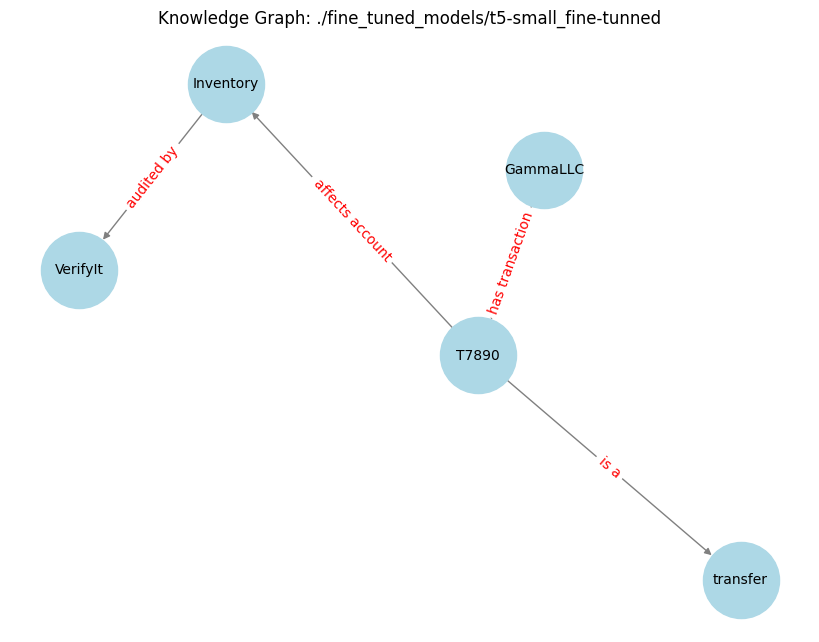


Model: facebook/bart-base

Key Sentences:
GammaLLC reported a transfer transaction with ID T7890 affecting Inventory account amounting to $75000. The transaction was audited by VerifyIt. An anomaly was detected in this transaction

Predicted Triples:
[('T7890', 'affects account', 'Inventory'), ('T7890', 'is a', 'transfer'), ('Inventory', 'audited by', 'VerifyIt'), ('VerifyIt', 'has anomaly', 'True'), ('GammaLLC', 'has transaction', 'T7890')]



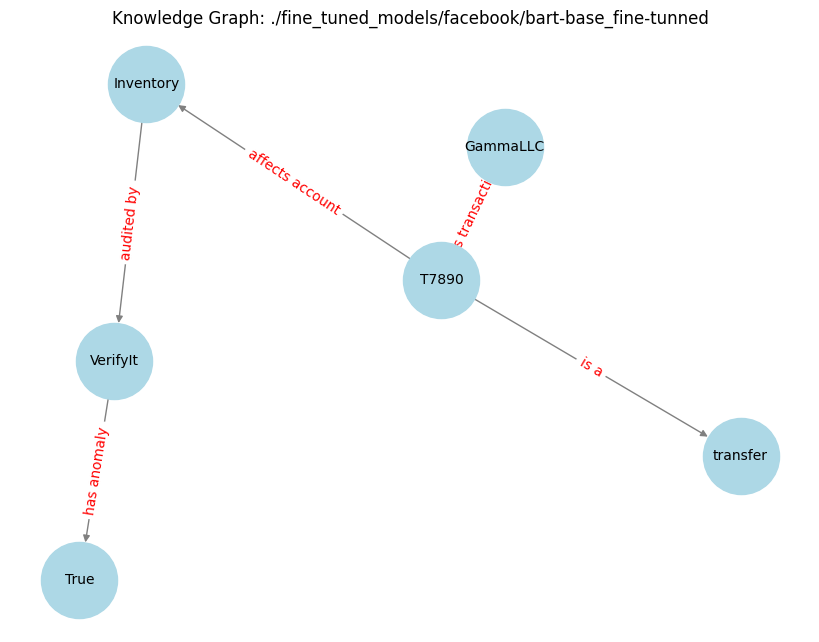


Model: google/flan-t5-small

Key Sentences:
The transaction was audited by VerifyIt

Predicted Triples:
[('Unknown_TID', 'audited by', 'VerifyIt')]



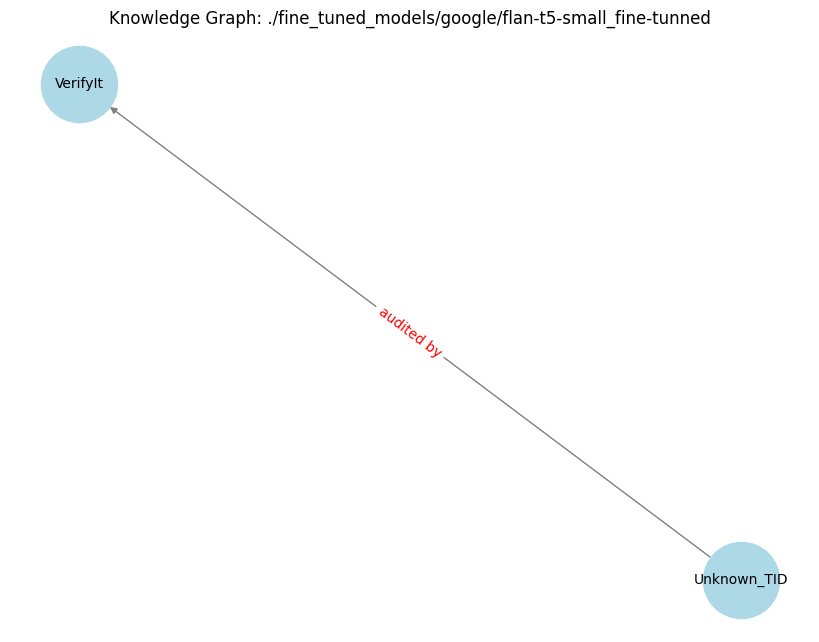

In [18]:

# ============================================
# 10. Inference on New Data with All Models
# ============================================

# Define a new input text for inference
new_text = (
    "GammaLLC reported a transfer transaction with ID T7890 affecting Inventory account amounting to $75000. "
    "The transaction was audited by VerifyIt. An anomaly was detected in this transaction."
)

print("\n===================================")
print("Running Inference on New Input with All Models")
print("===================================\n")

for model_name in models:
    print(f"\n{'='*40}")
    print(f"Model: {model_name}")
    print(f"{'='*40}\n")
    
    # Load the fine-tuned model and tokenizer
    pipeline_kg = KnowledgeGraphPipeline(model_name=f"./fine_tuned_models/{model_name}_fine-tunned")
    
    # Run the pipeline on the new input
    predicted_triples, graph = pipeline_kg.run_pipeline(
        text=new_text,
        true_triples=None,  # No ground truth for new input
        visualize=True
    )

# ============================================
# End of Script
# ============================================


This marks the conclusion of the script. By executing all the sections sequentially, the script comprehensively handles the generation of synthetic data, preprocessing, model training across multiple transformer architectures, evaluation of their performances, and application of the trained models to new data. The structured approach ensures modularity, making it easier to extend or modify individual components as needed. This holistic workflow provides a robust framework for developing and assessing models tailored to extract and represent financial knowledge from textual data.